# Imports

In [1]:
import os
from datetime import timedelta
from logging import INFO, basicConfig, info
from time import time

from numpy import digitize, percentile
from numpy.random import seed as npseed
from sklearn.model_selection import train_test_split as split
from torch import device as Device
from torch.backends.mps import is_available as mps_available
from torch.cuda import is_available as cuda_available
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# from segmentation_models_pytorch import Unet

from src.models.vitnet import VitNet

# from src.models.unet import Unet

from src.utils.dataset import ForestDataset
from src.utils.loss import loss
from src.utils.models import evaluation, load, save, training
from src.utils.plots import plot_image_and_prediction
from src.utils.predictions import predict_patch
from src.utils.preprocessing import Preprocessor

/Users/ematala/dev/tree-heights-germany/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Global parameters

In [2]:
patch_size = 256
img_dir = "data/images"
log_dir = "logs"
model_dir = "models"
patch_dir = f"data/patches/{patch_size}"
patches_file = f"data/patches/{patch_size}/info.fth"
gedi_file = "data/gedi/gedi_complete.fth"
seed = 42
batch_size = 8
num_workers = 6
learning_rate = 1e-4
epochs = 2
is_training = True
ranges = [(i, i + 5) for i in range(0, 50, 5)]
device = Device("cuda" if cuda_available() else "mps" if mps_available() else "cpu")

npseed(seed)
basicConfig(level=INFO)
# basicConfig(level=INFO, filename=os.path.join(log_dir, "main.log"), filemode="w")

info(f"Using {device} device")

INFO:root:Using mps device


# Preprocess labels and patches

In [3]:
# Create preprocessor
preprocessor = Preprocessor(patches_file, img_dir, patch_dir, gedi_file, patch_size)

preprocessor.run()

# Extract patches
patches = preprocessor.patches.sample(frac=1, random_state=seed)

info(f"Total number of patches: {len(patches)}")

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 49
INFO:root:Loaded existing patch info file. Skipping image processing.
INFO:root:Total number of patches: 9234


## Create datasets & dataloader

In [4]:
# Create quantiles and stratify
quantiles = percentile(patches.n_labels, [25, 50, 75])
stratify = digitize(patches.n_labels, quantiles)

# Split patches
train, rest = split(patches, test_size=0.3, random_state=seed, stratify=stratify)

stratify = stratify[patches.index.isin(rest.index)]

val, test = split(rest, test_size=0.5, random_state=seed, stratify=stratify)

# Create datasets
traindata = ForestDataset(train, patch_dir)
valdata = ForestDataset(val, patch_dir)
testdata = ForestDataset(test, patch_dir)

# Create dataloaders
trainloader = DataLoader(traindata, batch_size, True, num_workers=num_workers)
valloader = DataLoader(valdata, batch_size, False, num_workers=num_workers)
testloader = DataLoader(testdata, batch_size, False, num_workers=num_workers)

# U-Net

## Create model

In [5]:
model = VitNet().to(device)

info(model)

if is_training:
    # Create optimizer
    optimizer = Adam(model.parameters(), learning_rate)

    # Create writer
    writer = SummaryWriter(log_dir)

    # images, _ = next(iter(trainloader))

    # writer.add_images("images", images[:, :3, :, :].to(device))
    # writer.add_graph(model, images.to(device))

INFO:root:VitNet(
  (encoder): VitEncoder(
    (encoder): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(4, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (interme

## Train model

In [ ]:
if is_training:
    start = time()

    for epoch in range(epochs):
        training(trainloader, model, loss, device, writer, epoch, optimizer)
        evaluation(valloader, model, loss, device, writer, epoch)

    end = time()

    writer.close()

    info(f"Training completed in {timedelta(seconds=(end - start))}")

    score = evaluation(testloader, model, loss, device)

    info(f"Final loss on test set: {score}")

    info(f"Saving model {model.name}")

    save(model, os.path.join(model_dir, f"m-{model.name}-p{patch_size}-e{epochs}.pt"))
else:
    info(f"Loading model {model.name}")

    model = load(
        model,
        os.path.join(model_dir, f"m-{model.name}-p{patch_size}-e{epochs}.pt"),
        device,
    )

## Visualise results

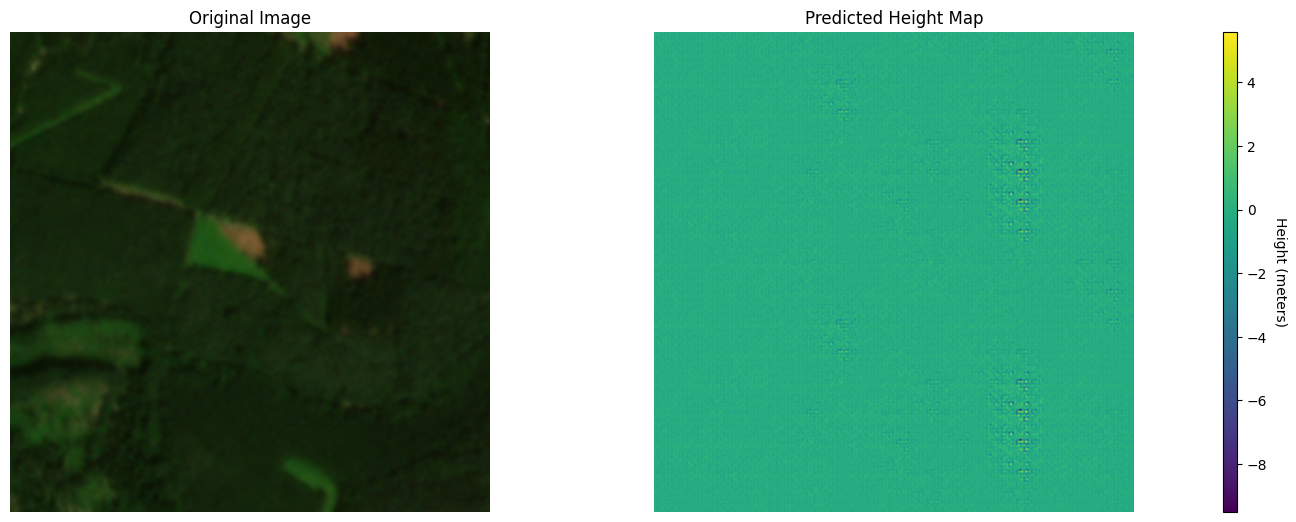

In [ ]:
idx = 42
patch = testdata[idx]
img, pred = predict_patch(model, patch, device)
plot_image_and_prediction(img, pred, 3)

In [ ]:
# image, prediction = predict_image(
#     model, device, "data/images/L15-1059E-1348N.tif", patch_size
# )

In [ ]:
# plot_image_and_prediction(image, prediction, 3)

In [ ]:
# save_prediction(prediction, os.path.join("results", "L15-1059E-1348N-P.tiff"))